In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms

from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [2]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-src/NPGMI Engine.ipynb"

### Wavelength distribution

In [3]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[::4], TOFcounts[::4]


TOF *= 1e-3
TOFcountsarea = np.trapz(TOFcounts) # area under curve
# TOFcountsarea = 1 # non-normalized

TOFcountsnormed = TOFcounts/TOFcountsarea # sum is 1

TOF = TOF[TOFcountsnormed > 2e-4]
jpplam = TOFcountsnormed[TOFcountsnormed > 2e-4]
# cuts out probabilities close to 0 (irrelevant)

def TOFtolambda(TOF, planck_const, mass, detector_dist):
    return TOF * planck_const / (mass * detector_dist)


m_neu = 1.6749275e-27
planck_const = 6.6261e-34
detector_dist = 23.854



jplam = TOFtolambda(TOF, planck_const, m_neu, detector_dist)

cutout_mask = (jplam >= 5e-10) & (jplam <= 6e-10)

In [4]:
# j, a = jplam, jpplam

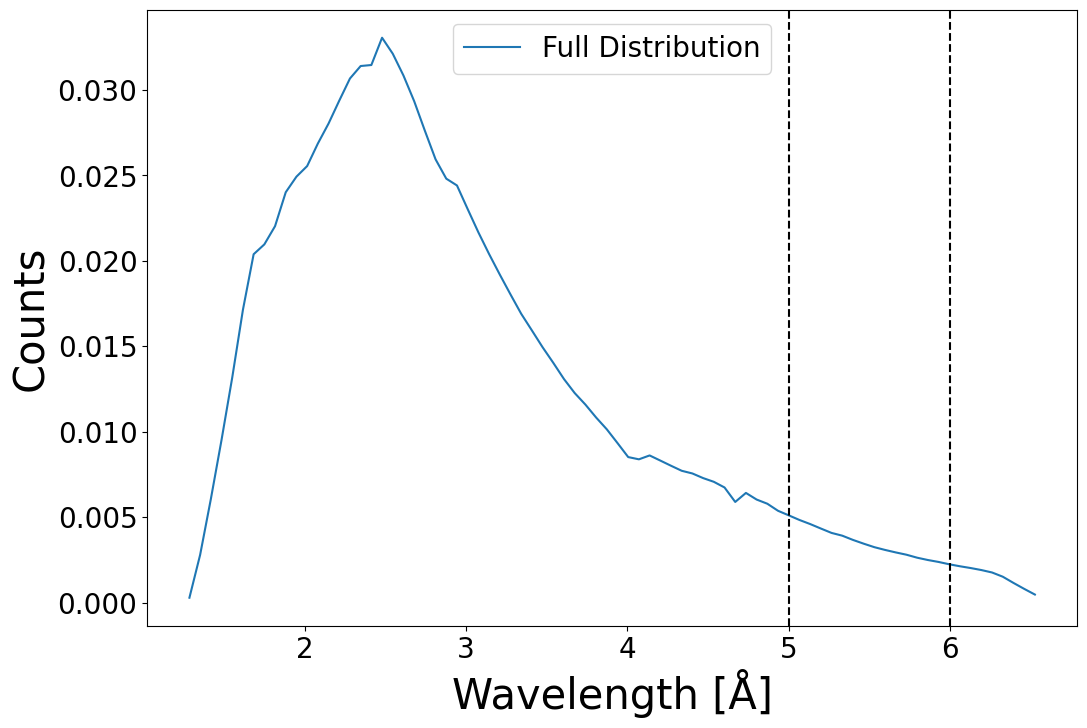

In [5]:
fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.plot(polyspectrum[0]*1e10,polyspectrum[1],lw = 4)
ax1.plot(jplam*1e10, jpplam, label = "Full Distribution")
# ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask], label = "5Å-6Å Cutout")

# ax1.plot(j*1e10, a, label = "Full Distribution")



ax1.set_xlabel("Wavelength [Å]", fontsize = 30)
ax1.set_ylabel("Counts", fontsize = 30)
ax1.tick_params(labelsize = 20)
ax1.axvline(5,color = "k", ls = "--")
ax1.axvline(6,color = "k", ls = "--")

ax1.legend(fontsize = 20, loc = "upper center")
# fig.savefig("jparcwavelengthdistwithcutout.png")

plt.show()
plt.close(fig)

### 2D Grating Data Analysis

In [6]:
# pxdata, pydata = 2.97e-6, 2.9e-6
pxdata, pydata = 3e-6, 3e-6


Ldatapoly = 8.2955
Ldatamono = 8.65
# Ldata = 8.352789
m_per_pixel = 6e-2/1944 # 6.32 cm camera total (for all 2048 pixels)


### Polychromatic 

In [7]:
t0 = time()
# camera rotates 90 degrees, so we transpose images

polydatapath = "/Users/macprorac2/Documents/Gabriel Dima's Group/Data/JPARC exp2 poly"

norm_img = tfl.imread(polydatapath  + "/" + os.listdir(polydatapath)[-1:][0])[:3]

# using first 3 images as normalization because they had ~0 contrast
norm_img[~np.isfinite(norm_img)] = 0

norm_img = np.mean(norm_img, axis = 0)

norm_img[norm_img == 0] = 1e6




rotdegs = [-10.1,-8.5,-7.4,-6.5,-5.8]

leftover_rot = [-5.2]

polyimages = [[process_tfl(img / (norm_img), rotdegs[j],5).T for j,img in enumerate(tfl.imread(polydatapath  + "/" + path)[3:])]\
                    for i, path in enumerate(os.listdir(polydatapath)[-1:])][0] + [process_tfl(tfl.imread(polydatapath  +\
                    "/" + "Result of Result of AVG_run059leftover.tif") / (norm_img), leftover_rot[0],5).T]

# findrotangle = np.arange(-15,0.1,0.1)

# polyimages = []

# for j in range(len(findrotangle)):
    
#     polyimages.append([process_tfl(img / (norm_img), findrotangle[j],5).T for i,img in \
#     enumerate(tfl.imread(polydatapath  + "/" + "Result of Result of AVG_run059fulldata.tif")[3:])] + \
#     [process_tfl(tfl.imread(polydatapath  + "/" + "Result of Result of AVG_run059leftover.tif") / (norm_img), findrotangle[j],5).T])



print(time() - t0, "seconds")

6.8064188957214355 seconds


In [8]:
# np.savetxt("best_2D_contrast_image.txt", polyimages[7], fmt = "%.18f", delimiter=",")

### Alignment

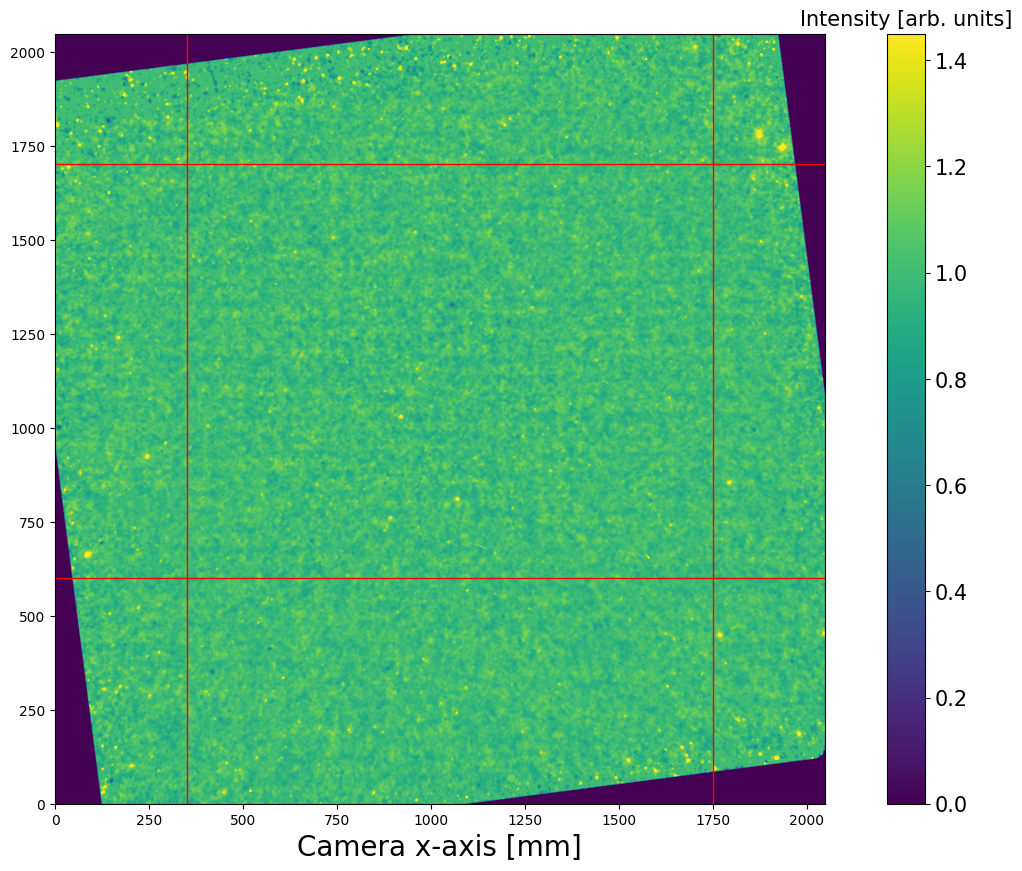

In [9]:
fig, ax = plt.subplots(figsize = (16,10))


ind = 2


c = ax.imshow(np.array(polyimages[ind]).T, origin = "lower", clim = (0,1.45))

cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title("Intensity [arb. units]", fontsize = 15)
ax.set_xlabel("Camera x-axis [mm]", fontsize = 20)

ax.axvline(350, color = "red", lw = 1)
ax.axvline(1750, color = "red", lw = 1)

ax.axhline(600, color = "red", lw = 1)
ax.axhline(1700, color = "red", lw = 1)


plt.show()
plt.close(fig)

In [14]:

polydataIx = np.array([np.sum(np.array(img)[...,600:1700,350:1750 ],axis = -2) for img in polyimages])
polydataIy = np.array([np.sum(np.array(img)[...,600:1700,350:1750 ],axis = -1) for img in polyimages])



ddata = (np.linspace(4.5,20.5,9)*1e-3)[3:]




In [15]:
polydataIx.shape

(6, 1400)

In [16]:
polydataIxfitparams, polydataIyfitparams = [], []
polydataIxerror, polydataIyerror = [], []
xdata, ydata = [],[]

for i, d in enumerate(ddata):
    x = np.arange(len(polydataIx[i]))*m_per_pixel
    y = np.arange(len(polydataIy[i]))*m_per_pixel
    
    xparams, xerr = best_fit_moire_period_with_error(cosine_func, x, polydataIx[i], pxdata, Ldatapoly, d, use_abs_sigma = True)
    yparams, yerr = best_fit_moire_period_with_error(cosine_func, y, polydataIy[i], pydata, Ldatapoly, d, use_abs_sigma = True)
    
    polydataIxfitparams.append(xparams)
    polydataIyfitparams.append(yparams)
    
    polydataIxerror.append(xerr)
    polydataIyerror.append(yerr)

    xdata.append(x)
    ydata.append(y)


# polydataIxfitparams, polydataIyfitparams = [], []
# xdata, ydata = [],[]

# for i, d in enumerate(ddata):
#     polydataIxfitparams.append([])
#     polydataIyfitparams.append([])
#     xdata.append([])
#     ydata.append([])
    
#     for j in range(len(findrotangle)):
    
#         x = np.arange(polydataIx[i][j].shape[-1])*m_per_pixel
#         y = np.arange(polydataIy[i][j].shape[-1])*m_per_pixel

#         polydataIxfitparams[-1].append(best_fit_moire_period(cosine_func, x, polydataIx[i][j], pxdata, Ldatapoly, d))
#         polydataIyfitparams[-1].append(best_fit_moire_period(cosine_func, y, polydataIy[i][j], pydata, Ldatapoly, d))

#         xdata[-1].append(x)
#         ydata[-1].append(y)

polydataIxfitparams, polydataIyfitparams = np.array(polydataIxfitparams),np.array(polydataIyfitparams)
polydataIxerror, polydataIyerror = np.array(polydataIxerror), np.array(polydataIyerror)

polyxdatafreq = 1/polydataIxfitparams[...,2]
polyydatafreq = 1/polydataIyfitparams[...,2]

polycontx = np.abs(polydataIxfitparams[...,1]/polydataIxfitparams[...,0])
polyconty = np.abs(polydataIyfitparams[...,1]/polydataIyfitparams[...,0])

In [17]:
polycontxerror = polycontx * np.sqrt((polydataIxerror[...,1]/polydataIxfitparams[...,1])**2 +\
                (polydataIxerror[...,0]/polydataIxfitparams[...,0])**2)

polycontyerror = polyconty * np.sqrt((polydataIyerror[...,1]/polydataIyfitparams[...,1])**2 +\
                (polydataIyerror[...,0]/polydataIyfitparams[...,0])**2)

In [18]:
polydataIxfitparams[...,1]

array([ 14.91847679, -16.88047203, -18.44016848,  19.95993797,
       -18.81308022,  17.97563554])

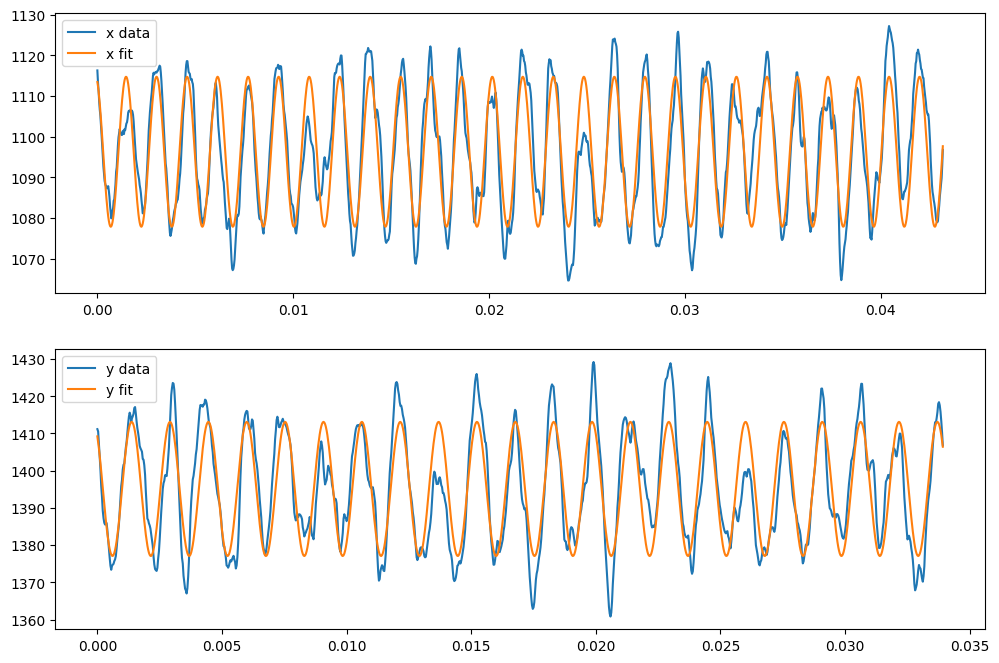

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,8))

ind = 2

ax1.plot(xdata[ind], polydataIx[ind], label = "x data")
# ax1.errorbar(xdata[ind], polydataIx[ind], yerr=np.sqrt(polydataIx[ind]), elinewidth=1, capsize=5, label = "x data")

ax1.plot(xdata[ind], cosine_func(xdata[ind], *polydataIxfitparams[ind]), label = "x fit")

ax2.plot(ydata[ind], polydataIy[ind], label = "y data")
ax2.plot(ydata[ind], cosine_func(ydata[ind], *polydataIyfitparams[ind]), label = "y fit")

# ax1.set_xlim(0,0.01)
ax1.legend()
ax2.legend()

plt.show()
plt.close(fig)

In [20]:
# L0poly = 5e-1

# d0poly = -1e-3

d0polyx, L0polyx = curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldatapoly,L0,pxdata),ddata,\
                polyxdatafreq, p0 = [-1e-3,-10e-2],maxfev = 10000)[0]

d0polyy, L0polyy = curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldatapoly,L0,pydata),ddata,\
                polyydatafreq, p0 = [-1e-3,-10e-2],maxfev = 10000)[0]

polyxfreq = 1/((Ldatapoly - L0polyx)*pxdata/(ddata - d0polyx))

# d0poly, L0poly = curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldatapoly,L0,pydata),ddata,\
#                 polyydatafreq, p0 = [-1e-3,-10e-2],maxfev = 10000)[0]

polyyfreq = 1/((Ldatapoly - L0polyy)*pydata/(ddata - d0polyy))

In [21]:
print((L0polyx - L0polyy)*1e2)

-6.365933104878188


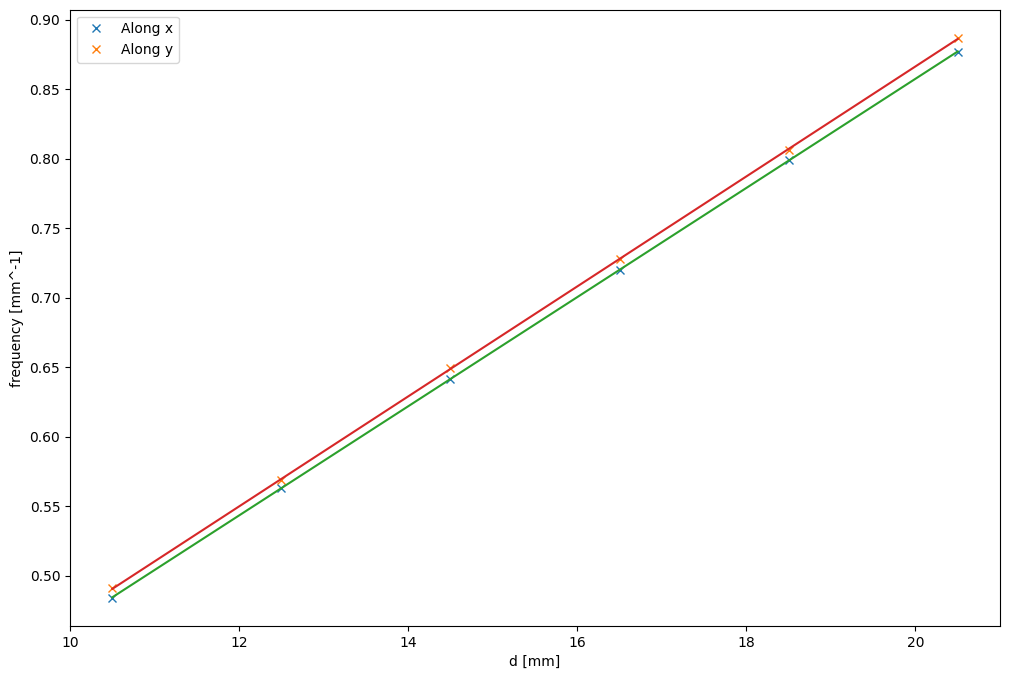

In [22]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.plot(ddata*1e3, polyxdatafreq * 1e-3, "x", label = "Along x")
ax1.plot(ddata*1e3, polyydatafreq * 1e-3, "x", label = "Along y")

ax1.plot(ddata*1e3, polyxfreq*1e-3)
ax1.plot(ddata*1e3, polyyfreq*1e-3)

ax1.set_xlabel("d [mm]")
ax1.set_ylabel("frequency [mm^-1]")

ax1.legend()
plt.show()
plt.close(fig)

### Monochromatic (TOF-Resolved)

In [23]:
t0 = time()

monodatapath = "/Users/macprorac2/Documents/Gabriel Dima's Group/Data/JPARC exp2 mono"

norm_img = tfl.imread(monodatapath  + "/" + "NID019771_20230217.tiff")

ddatamono = np.array([8.5,12.5])*1e-3
# two file sets (one for each d) but contrast sucks for the first so we ignore

m_per_pixel_camera2 = 100e-6

img_names = [["NID019780_20230219.tiff"], ["NID019772_20230217.tiff","NID019773_20230218.tiff",\
            "NID019774_20230218.tiff","NID019778_20230218.tiff"]]

rotdegs = [-17.7, -13.3]



# approximately 6 frames (or images) per angstrom since the frames are 1 ms bins, 2A starts at frame 12
n_bins = 4
lam_bins = np.array([2,3,4,5,6])
# last frames sucks as well, low counts 
# first real itensity is at frame 10


# findrotangle =  np.arange(-20,-4.5,0.5)

# print(findrotangle.shape)



    
allmonoimages = np.array([tfl.imread(monodatapath  + "/" + name) for name in img_names[1]])
# several files with same d but different counter rotations (CR)

print(allmonoimages.shape)

binnedimages = [] 



totalimage = np.mean(allmonoimages[:,10:-2],axis = 1)
totalempty = np.mean(norm_img[10:-2],axis = 0)
totalempty[totalempty == 0] = 1e6

print(totalimage.shape, totalempty.shape)

totalimage_CR = []

# for CR_i in range(len(allmonoimages)):
#     binnedimages.append([])
#     totalimage_rot.append([])
    
#     for deg in findrotangle:
#         if deg % 5 == 0:
#             print("CR_i = ", CR_i, "deg = ", deg)

#         binnedimages[-1].append([])
#         for i in range(n_bins):
            
#             if i == 4:
#                 # print(allmonoimages[CR_i,6*i + 12:-1].shape)
#                 image = np.mean(allmonoimages[CR_i,6*i + 12:-1],axis = 0)

#                 empty = np.mean(norm_img[6*i + 12:-1], axis = 0)
#             else:
#                 image = np.mean(allmonoimages[CR_i,6*i + 12:6*(i+1) + 12],axis = 0)

#                 empty = np.mean(norm_img[6*i + 12:6*(i+1) + 12], axis = 0)

#             empty[empty == 0] = 1e6

#             binnedimages[-1][-1].append(process_tfl((image/empty).T, deg,5))
        
#         totalimage_rot[-1].append(process_tfl((totalimage[CR_i]/totalempty).T, deg,5))


for CR_i in range(len(allmonoimages)):
    binnedimages.append([])
    
    
    for i in range(n_bins):

#         if i == n_bins - 1:
#             # print(allmonoimages[CR_i,6*i + 12:-1].shape)
#             image = np.mean(allmonoimages[CR_i,6*i + 12:-2],axis = 0)

#             empty = np.mean(norm_img[6*i + 12:-2], axis = 0)
#         else:
        image = np.mean(allmonoimages[CR_i,6*i + 12:6*(i+1) + 12],axis = 0)

        empty = np.mean(norm_img[6*i + 12:6*(i+1) + 12], axis = 0)

        empty[empty == 0] = 1e6

        # binnedimages[-1].append(process_tfl((image/empty).T, rotdegs[1],5))
        binnedimages[-1].append(process_tfl((image/empty).T, rotdegs[1]))


    # totalimage_CR.append(process_tfl((totalimage[CR_i]/totalempty).T, rotdegs[1],5))
    totalimage_CR.append(process_tfl((totalimage[CR_i]/totalempty).T, rotdegs[1]))
        
print(time() - t0, "seconds")


(4, 40, 1024, 1024)
(4, 1024, 1024) (1024, 1024)
1.599982738494873 seconds


### Alignment 

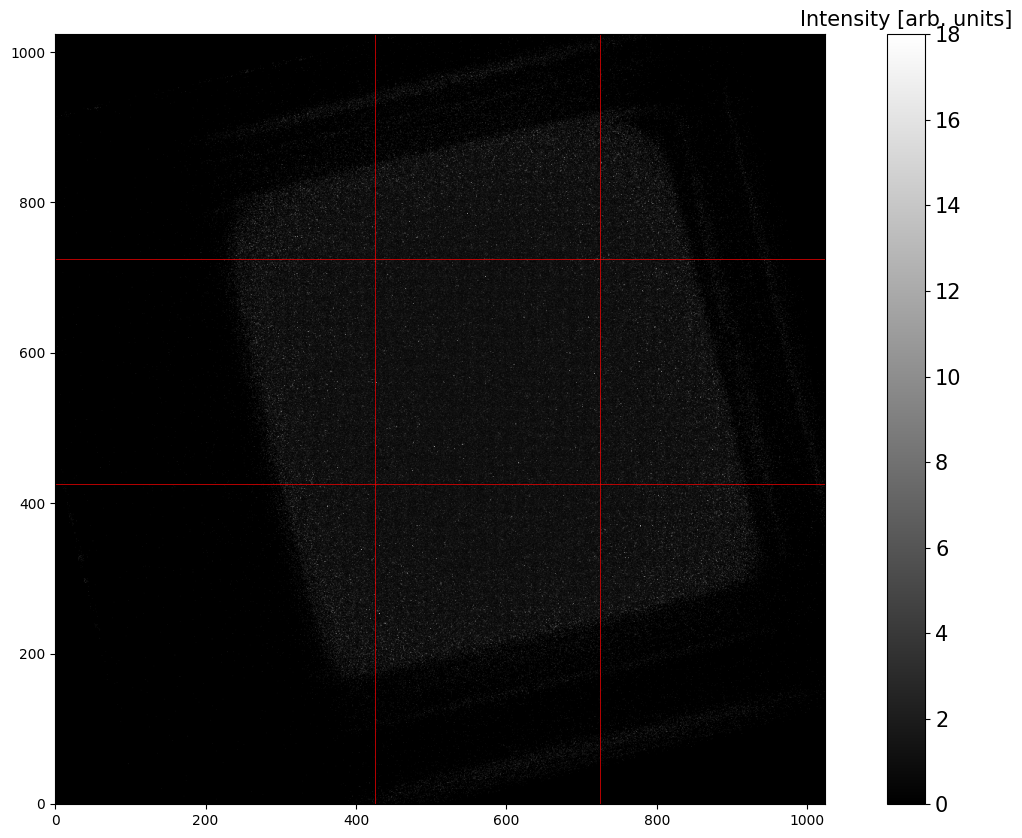

In [24]:
fig, ax = plt.subplots(figsize = (16,10))


test = np.copy(binnedimages[2][-1])
# test[425:725, 425:725] = 1

c = ax.imshow(test, origin = "lower", cmap = "gray")
ax.axhline(425, color = "red", lw = 0.5)
ax.axvline(425, color = "red", lw = 0.5)

ax.axhline(725, color = "red", lw = 0.5)
ax.axvline(725, color = "red", lw = 0.5)


cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title("Intensity [arb. units]", fontsize = 15)
# ax.set_xlabel("Camera x-axis [mm]", fontsize = 20)




# fig.savefig("2Dbestcontrastwithregionmonointensity5-6A.png")
plt.show()
plt.close(fig)

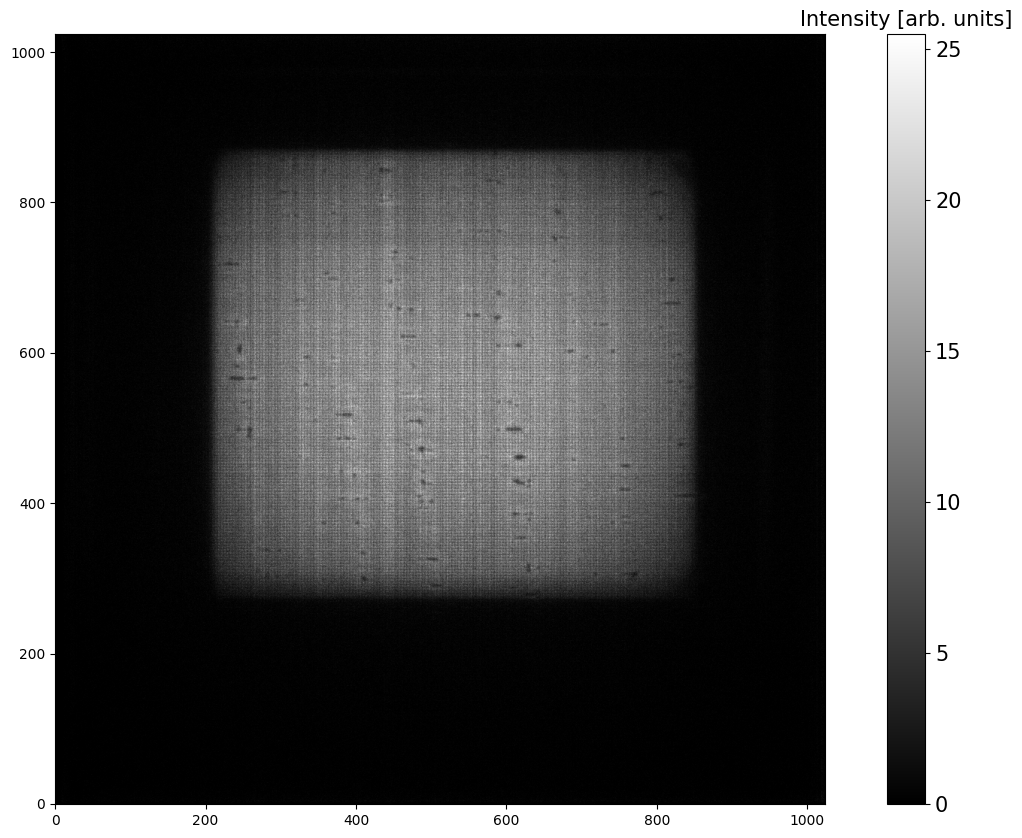

In [25]:
fig, ax = plt.subplots(figsize = (16,10))

ind = 0
c = ax.imshow(np.mean(norm_img[6*ind + 12:6*(ind+1) + 12], axis = 0), origin = "lower", cmap = "gray")
# ax.axhline(425, color = "red", lw = 0.5)
# ax.axvline(425, color = "red", lw = 0.5)

# ax.axhline(725, color = "red", lw = 0.5)
# ax.axvline(725, color = "red", lw = 0.5)


cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title("Intensity [arb. units]", fontsize = 15)
# ax.set_xlabel("Camera x-axis [mm]", fontsize = 20)




# fig.savefig("JPARCbackground.png")
plt.show()
plt.close(fig)

In [22]:
# print(np.array(binnedimages)[2,-1, 425:725, 425:725].shape)
# np.savetxt("2DmonoROI.csv", np.array(binnedimages)[2,-1, 425:725, 425:725], fmt = "%.18f", delimiter=",")

In [26]:
monodataIx = np.sum(np.array(binnedimages)[2,...,425:725, 425:725],axis = -2)
monodataIy = np.sum(np.array(binnedimages)[2,...,425:725, 425:725],axis = -1)

totalIx = np.sum(np.array(totalimage_CR)[2,...,425:725, 425:725],axis = -2)
totalIy = np.sum(np.array(totalimage_CR)[2,...,425:725, 425:725],axis = -1)

In [27]:

x = np.arange(totalIx.shape[-1])*m_per_pixel_camera2
y = np.arange(totalIy.shape[-1])*m_per_pixel_camera2

# totalIxfitparams, totalIyfitparams = [], []
# totalIxerror, totalIyerror = [], []

# for CR_i in range(len(totalIx)):

xparams, xerr = best_fit_moire_period_with_error(cosine_func, x, totalIx, pxdata, Ldatamono, ddatamono[1], use_abs_sigma = True)
yparams, yerr = best_fit_moire_period_with_error(cosine_func, y, totalIy, pydata, Ldatamono, ddatamono[1], use_abs_sigma = True)

totalIxfitparams = xparams
totalIyfitparams = yparams

totalIxerror = xerr
totalIyerror = yerr

    # xparams, xerr = best_fit_moire_period_with_error(cosine_func, x, totalIx[CR_i], pxdata, Ldatamono, ddatamono[1])
    # yparams, yerr = best_fit_moire_period_with_error(cosine_func, y, totalIy[CR_i], pydata, Ldatamono, ddatamono[1])

    # totalIxfitparams.append(xparams)
    # totalIyfitparams.append(yparams)

    # totalIxerror.append(xerr)
    # totalIyerror.append(yerr)


totalIxdatamono = x
totalIydatamono = y

totalIxfitparams, totalIyfitparams = np.array(totalIxfitparams), np.array(totalIyfitparams)
totalIxerror, totalIyerror = np.array(totalIxerror), np.array(totalIyerror)


totalIxfreq = 1/totalIxfitparams[...,2]
totalIyfreq = 1/totalIyfitparams[...,2]

totalcontx = np.abs(totalIxfitparams[...,1]/totalIxfitparams[...,0])
totalconty = np.abs(totalIyfitparams[...,1]/totalIyfitparams[...,0])

In [28]:
totalIyfreq

559.6526848838546

In [29]:
monodataIxfitparams, monodataIyfitparams = [], []
monodataIxerror, monodataIyerror = [], []

x, y = np.arange(monodataIx.shape[-1])*m_per_pixel_camera2, np.arange(monodataIy.shape[-1])*m_per_pixel_camera2


chi2s_x, chi2s_y = [],[]
    
    
# for CR_i in range(len(allmonoimages)):
#     monodataIxfitparams.append([])
#     monodataIyfitparams.append([])

#     monodataIxerror.append([])
#     monodataIyerror.append([])
    
#     fx, fy = totalIxfreq[CR_i], totalIyfreq[CR_i]

#     def enforced_freq_cosine_x(x,A,B,phi):
#         return A + B*np.cos(2*pi*fx*x + phi)

#     def enforced_freq_cosine_y(y,A,B,phi):
#         return A + B*np.cos(2*pi*fy*y + phi)


#     for i in range(n_bins):

#         xparams, xerr = curve_fit(enforced_freq_cosine_x,x,monodataIx[CR_i][i])
#         yparams, yerr = curve_fit(enforced_freq_cosine_y,y,monodataIy[CR_i][i])

#         monodataIxfitparams[-1].append(xparams)
#         monodataIyfitparams[-1].append(yparams)

#         monodataIxerror[-1].append(np.sqrt(np.diag(xerr)))
#         monodataIyerror[-1].append(np.sqrt(np.diag(yerr)))

fx, fy = totalIxfreq, totalIyfreq

def enforced_freq_cosine_x(x,A,B,phi):
    return A + B*np.cos(2*pi*fx*x + phi)

def enforced_freq_cosine_y(y,A,B,phi):
    return A + B*np.cos(2*pi*fy*y + phi)


for i in range(n_bins):

    xparams, xerr = curve_fit(enforced_freq_cosine_x,x,monodataIx[i], sigma = np.sqrt(monodataIx[i]),\
                    absolute_sigma = True, maxfev = 20000)
    yparams, yerr = curve_fit(enforced_freq_cosine_y,y,monodataIy[i], sigma = np.sqrt(monodataIy[i]),\
                    absolute_sigma = True, maxfev = 20000)

    monodataIxfitparams.append(xparams)
    monodataIyfitparams.append(yparams)

    monodataIxerror.append(np.sqrt(np.diag(xerr)))
    monodataIyerror.append(np.sqrt(np.diag(yerr)))
    
    

    
xdatamono, ydatamono = np.array(x), np.array(y)

monodataIxfitparams, monodataIyfitparams = np.array(monodataIxfitparams),np.array(monodataIyfitparams)
    
monodataIxerror, monodataIyerror = np.array(monodataIxerror), np.array(monodataIyerror)


monocontx = np.abs(monodataIxfitparams[...,1]/monodataIxfitparams[...,0])
monoconty = np.abs(monodataIyfitparams[...,1]/monodataIyfitparams[...,0])

monocontxerror = monocontx * np.sqrt((monodataIxerror[...,1]/monodataIxfitparams[...,1])**2 +\
                         (monodataIxerror[...,0]/monodataIxfitparams[...,0])**2)

monocontyerror = monoconty * np.sqrt((monodataIyerror[...,1]/monodataIyfitparams[...,1])**2 +\
                         (monodataIyerror[...,0]/monodataIyfitparams[...,0])**2)




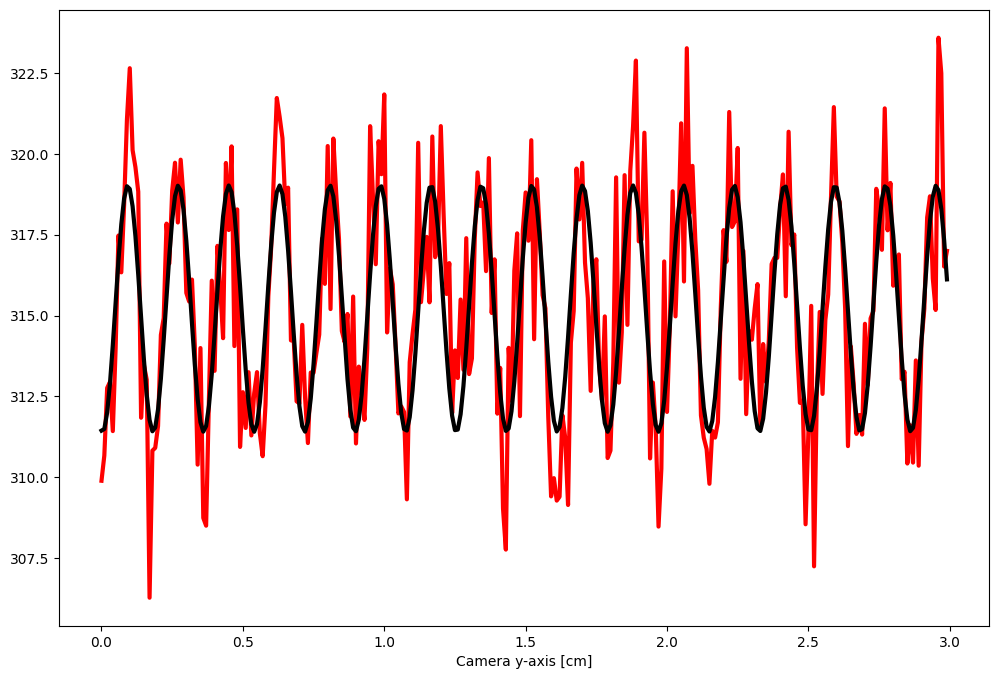

In [30]:
fig, ax1 = plt.subplots(figsize = (12,8))


ax1.set_prop_cycle(color = ["red","black"])
# CR_ind = -1
ind = 3


ax1.plot(ydatamono*1e2, totalIy, lw = 3)
ax1.plot(ydatamono*1e2, cosine_func(ydatamono, *totalIyfitparams),\
        lw = 3)

ax1.set_xlabel("Camera y-axis [cm]")

# ax1.grid()
# ax2.grid()
# ax1.legend()
# ax2.legend()

# fig.savefig("2Dbestcontrastmonointensityalongyfit.png")


plt.show()
plt.close(fig)

In [28]:
# np.savetxt("y_intensity_2-3A.csv", np.vstack([y,monodataIy[0]]).T,fmt = "%.18f", delimiter= ",")
# np.vstack([y,monodataIy[0]]).shape

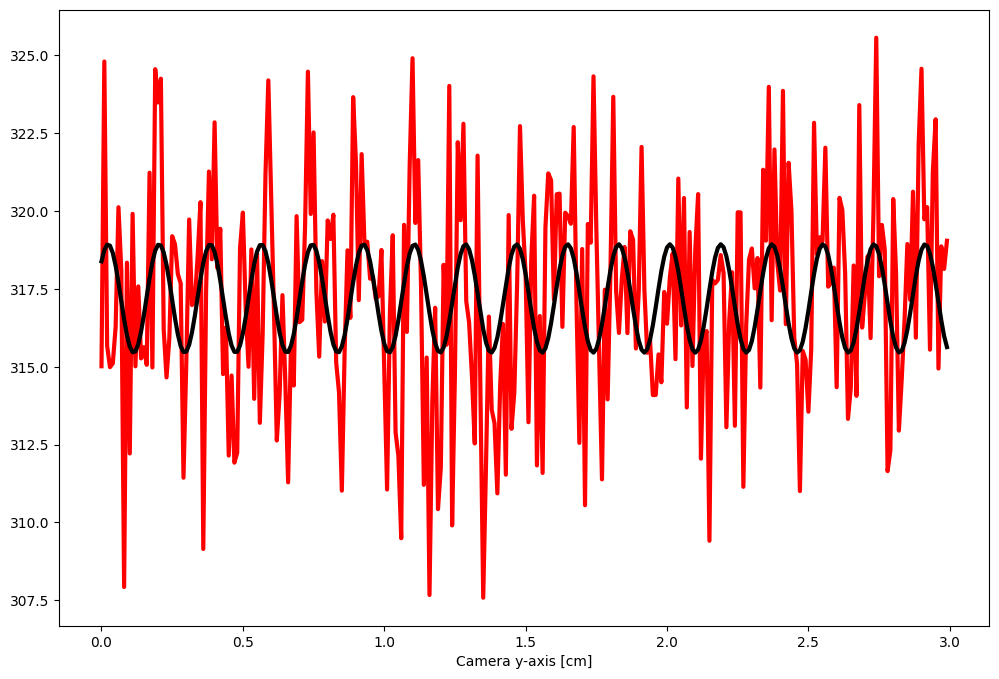

In [31]:
# fig, (ax1, ax2) = plt.subplots(2,1,figsize = (12,8))
fig, ax1 = plt.subplots(figsize = (12,8))


ax1.set_prop_cycle(color = ["red","black"])
# CR_ind = -1
ind = 0
# for i in range(len(monocontx[CR_ind]))[-2:-1]:

ax1.plot(xdatamono*1e2, monodataIx[ind], lw = 3,label = "%.1f-%.1fA, x data" % (lam_bins[ind],lam_bins[ind+1]))
# ax1.errorbar(xdatamono*1e2, monodataIx[ind], yerr = np.sqrt(monodataIx[ind]), elinewidth=1, capsize=5, lw = 3,label = "%.1f-%.1fA, x data" % (lam_bins[ind],lam_bins[ind+1]))

ax1.plot(xdatamono*1e2, enforced_freq_cosine_x(xdatamono, *monodataIxfitparams[ind]),lw = 3,\
        label = "%.1f-%.1fA, x fit" % (lam_bins[ind],lam_bins[ind+1]))



# ax1.plot(ydatamono*1e2, monodataIy[ind], lw = 3,label = "%.1f-%.1fA, y data" % (lam_bins[ind],lam_bins[ind+1]))
# ax1.plot(ydatamono*1e2, enforced_freq_cosine_y(ydatamono, *monodataIyfitparams[ind]),\
#         lw = 3,label = "%.1f-%.1fA, y fit" % (lam_bins[ind],lam_bins[ind+1]))

ax1.set_xlabel("Camera y-axis [cm]")

# ax1.set_xlim(0,0.3)
# ax1.legend()
# ax2.legend()

# fig.savefig("2Dbestcontrastmonointensityalongyfit.png")


plt.show()
plt.close(fig)

In [30]:
d0polyy*1e3

-1.892822970638745

In [31]:
ddata

array([0.0105, 0.0125, 0.0145, 0.0165, 0.0185, 0.0205])

In [32]:
d0polyx

-0.0018321524842896634


### Polychromatic Simulations

In [70]:
px, py = 3e-6, 3e-6


Nbc = 5e28*4.149e-15
mt = 5

Lpoly = 8.2955 - L0polyx


lam, plam = jplam, jpplam


h = 8.53e-6


phi = Nbc*lam*h



slitx = 642e-6
slity = 783e-6
mult_opt = 1.12

slitx_vals = np.arange(635, 650, 1)*1e-6
slity_vals = np.arange(775, 795, 1)*1e-6

xbin = 1e-6
ybin = 1e-6

res = m_per_pixel


dsimpoly = np.linspace(ddata[0], ddata[-1], 40) - d0polyx
# dsimpoly = ddata - d0polyx


L1poly = 4.156 - (dsimpoly - dsimpoly[0])/2

G1sd = {"px":px, "py":py,"L1": L1poly, "phi":phi, "mt": mt, "spectrum_spacing":1, "n_p_g":10}
G1sd["L2"] = dsimpoly



G2sd = {"px":px, "py":py, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi, "mt": mt, "spectrum_spacing":1, "n_p_g":10}
G2sd["L2"] = Lpoly - (G1sd["L1"] + G1sd["L2"])



camsize = 1e-2
x,y = np.arange(-camsize/8,camsize/8+xbin,xbin), np.arange(-camsize/10,camsize/10 + ybin,ybin)



simapts = {"G1":RectGrating2D(G1sd), "G2":RectGrating2D(G2sd)}




siminit = {"lam":lam, "plam": plam,"sum_lam":True,  "L":Lpoly,"d":dsimpoly,"mt":mt,"xbin":xbin,"ybin":ybin,\
            "gravity":True,"convmode" : "valid", "slitx": slitx, "slity" : slity,"resx": res,"resy": res, "x":x, "y":y,\
            "batches": 10, "cam_rotdeg": 13.3}


In [71]:
sim2d = PGMI(simapts, siminit)
sim2d.propagate_to("G1")
sim2d.propagate_to("G2")
sim2d.generate_after("G2")

(6, 80, 121, 121) (6, 80, 121) (6, 80, 121) 

(6, 80, 121, 121) (6, 121) (6, 121) 



In [57]:
t0 = time()

contrast_x, contrast_y = [],[]

for i, slitx in enumerate(slitx_vals):
    contrast_x.append([])
    contrast_y.append([])
    for j, slity in enumerate(slity_vals):

        clear_output(wait = True)
        print("%.2f %% done" % (i/len(slitx_vals) * 1e2))


        siminit = {"lam":lam, "plam": plam,"sum_lam":True,  "L":Lpoly,"d":dsimpoly,"mt":mt,"xbin":xbin,"ybin":ybin,\
            "gravity":True,"convmode" : "valid", "slitx": slitx, "slity" : slity,"resx": res,"resy": res, "x":x, "y":y,\
            "batches": 10, "cam_rotdeg": 13.3}

        sim2d = PGMI(simapts, siminit)
        sim2d.propagate_to("G1")
        sim2d.propagate_to("G2")
        sim2d.generate_after("G2")

        contrast_x[-1].append(sim2d.contrast_x)
        contrast_y[-1].append(sim2d.contrast_y)
        




print(time() - t0, "seconds")


93.33 % done
(6, 80, 121, 121) (6, 80, 121) (6, 80, 121) 

(6, 80, 121, 121) (6, 121) (6, 121) 

236.32467675209045 seconds


In [58]:
contrast_x, contrast_y = np.moveaxis(contrast_x, -1,0)[argminerr[1]], np.moveaxis(contrast_y, -1,0)[argminerr[1]]
contrast_x, contrast_y = np.moveaxis(contrast_x, -1,0), np.moveaxis(contrast_y, -1,0)

# contrast_x =  np.load("contxfitslit.npy")
# contrast_y =  np.load("contyfitslit.npy")

# contrast_x, contrast_y = contrast_x[argminerr[1]], contrast_y[argminerr[1]]


# contrast_x = sim2d.contrast_x[:, argminerr[1]]
# contrast_y = sim2d.contrast_y[:, argminerr[1]]

In [59]:
np.array(contrast_x).shape

(6, 15, 20)

In [60]:
cont_mult_factors = np.arange(0.6, 1.3, 0.01)

err_polycontx = polycontxerror.copy()
err_polyconty = polycontyerror.copy()



contrast_x, polycontx, err_polycontx, cont_mult_factors  = force_broadcast(contrast_x, polycontx, err_polycontx, cont_mult_factors)
contrast_y, polyconty, err_polyconty, cont_mult_factors  = force_broadcast(contrast_y, polyconty, err_polyconty, cont_mult_factors)

contfitxerr = np.sum(((polycontx - (contrast_x*cont_mult_factors))/err_polycontx)**2, axis = get_param_axis(contrast_x, dsimpoly))

contfityerr = np.sum(((polyconty - (contrast_y*cont_mult_factors))/err_polyconty)**2, axis = get_param_axis(contrast_y, dsimpoly))


contfitxerr, contfityerr = force_broadcast(contfitxerr, contfityerr)
contfitxyerr = np.sqrt(contfitxerr + contfityerr)

print(contfitxyerr.shape)





# argminerr = min_index(np.array(phasefitxyerr))



polyargminerr = min_index(np.array(contfitxyerr))




(15, 20, 70)


In [61]:
polyargminerr

(7, 8, 52)

In [62]:
contrast_y.shape

(6, 15, 20, 1)

In [63]:
polycontx, contrast_x, cont_mult_factors, polyconty, contrast_y, cont_mult_factors, polycontxerror, polycontyerror =\
[np.squeeze(i) for i in [polycontx, contrast_x, cont_mult_factors, polyconty, contrast_y, cont_mult_factors, polycontxerror, polycontyerror]]


mult_opt, slitx_opt, slity_opt = cont_mult_factors[polyargminerr[-1]],slitx_vals[polyargminerr[0]], slity_vals[polyargminerr[1]]
print(mult_opt, slitx_opt, slity_opt)

1.1200000000000006 0.000642 0.000783


<ErrorbarContainer object of 3 artists>

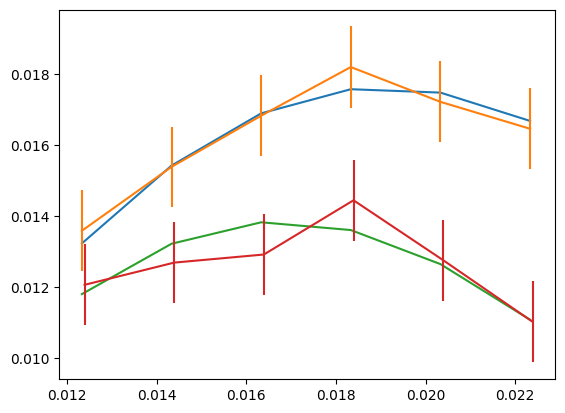

In [64]:
plt.plot(dsimpoly, contrast_x[:,polyargminerr[0],polyargminerr[1]] * mult_opt)
plt.errorbar((ddata - d0polyx),polycontx, yerr=polycontxerror)

plt.plot(dsimpoly, contrast_y[:,polyargminerr[0],polyargminerr[1]] * mult_opt)
plt.errorbar((ddata - d0polyy),polyconty, yerr=polycontyerror)

In [270]:
contfitxyerr[polyargminerr]

1.4047130057238704

In [286]:
slitx_uncertainty = np.abs(slitx_vals[np.argmin(np.abs(contfitxyerr[:, polyargminerr[1], polyargminerr[2]] - 2*contfitxyerr[polyargminerr]))]\
                    - slitx_opt)
slity_uncertainty = np.abs(slity_vals[np.argmin(np.abs(contfitxyerr[polyargminerr[0], :, polyargminerr[2]] - 2*contfitxyerr[polyargminerr]))]\
                    - slity_opt)
mult_uncertainty = np.abs(cont_mult_factors[np.argmin(np.abs(contfitxyerr[polyargminerr[0], polyargminerr[1], :] - 2*contfitxyerr[polyargminerr]))]\
                    - mult_opt)

In [310]:
slity_uncertainty*1e6

11.00000000000005

In [305]:
argminerr

(0, 0, 17, 60)

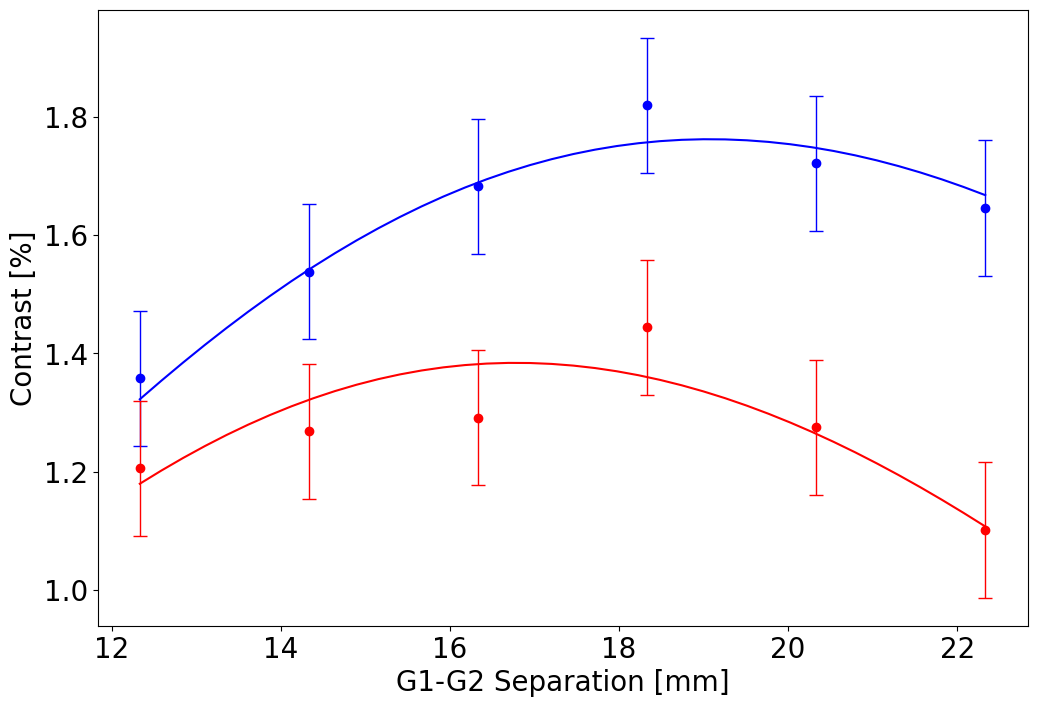

In [68]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.set_prop_cycle(color = ["blue", "red"])

ax1.errorbar((ddata - d0polyx)*1e3, polycontx*1e2,polycontxerror*1e2, fmt = "o",capsize = 5, elinewidth = 1, label = "Data; Along x")
ax1.errorbar((ddata - d0polyx)*1e3, polyconty*1e2,polycontyerror*1e2, fmt = "o",capsize = 5, elinewidth = 1, label = "Data; Along y")

ax1.plot(dsimpoly*1e3, sim2d.contrast_x[:,argminerr[1]]*1e2*mult_opt, label = "Simulation; Along x")
ax1.plot(dsimpoly*1e3, sim2d.contrast_y[:,argminerr[1]]*1e2*mult_opt, label = "Simulation; Along y")

# ax1.plot(dsimpoly*1e3, contrast_x[:,polyargminerr[0],polyargminerr[1]]*1e2*mult_opt, label = "Simulation; Along x")
# ax1.plot(dsimpoly*1e3, contrast_y[:,polyargminerr[0],polyargminerr[1]]*1e2*mult_opt, label = "Simulation; Along y")



ax1.set_xlabel("G1-G2 Separation [mm]", fontsize = 20)
ax1.set_ylabel("Contrast [%]", fontsize = 20)
ax1.tick_params(labelsize = 20)

# ax1.set_title("2D Gratings Contrast vs. d")

# ax1.legend()
fig.savefig("2Dpolycontrastxy.png", bbox_inches = "tight")
plt.show()
plt.close(fig)

In [295]:
dsimpoly

array([0.01233215, 0.01433215, 0.01633215, 0.01833215, 0.02033215,
       0.02233215])

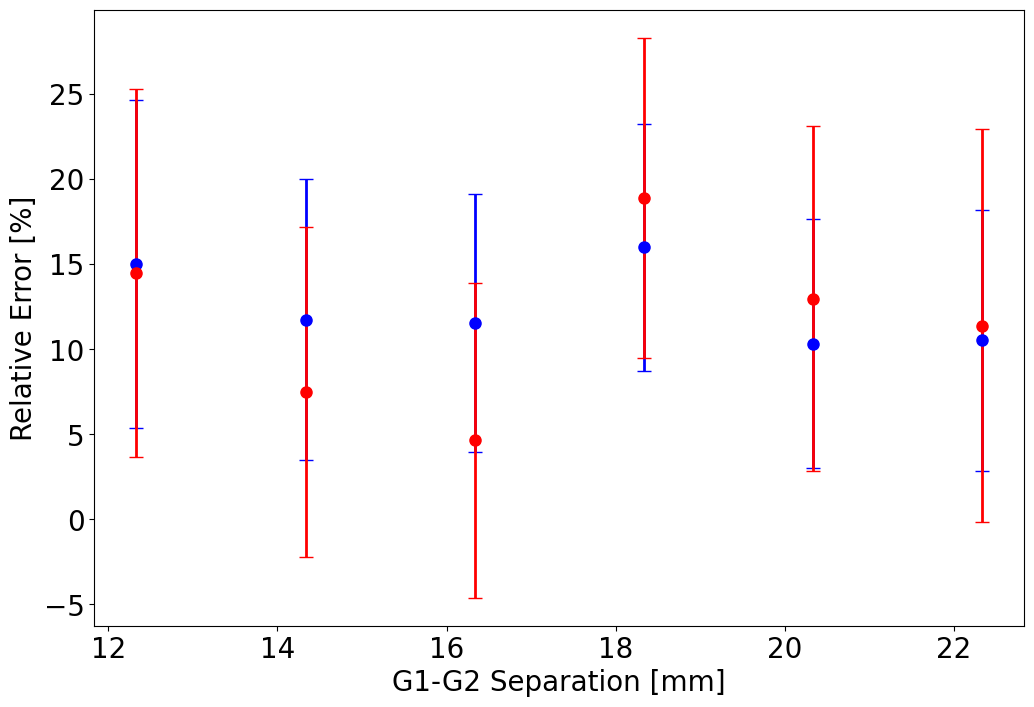

In [72]:
fig, ax1 = plt.subplots(figsize = (12,8))


ax1.set_prop_cycle(color = ["blue", "red"])      
ax1.errorbar(dsimpoly*1e3, (np.abs(polycontx - contrast_x[:,polyargminerr[0],polyargminerr[1]])/contrast_x[:,polyargminerr[0],polyargminerr[1]]) * 1e2,\
             yerr = (polycontxerror/contrast_x[:,polyargminerr[0],polyargminerr[1]])*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, x",fmt = "o", markersize = 8)

ax1.errorbar(dsimpoly*1e3,(np.abs(polyconty - contrast_y[:,polyargminerr[0],polyargminerr[1]])/contrast_y[:,polyargminerr[0],polyargminerr[1]]) * 1e2,\
             yerr = (polycontyerror/contrast_y[:,polyargminerr[0],polyargminerr[1]])*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, y",fmt = "o", markersize = 8)



# ax1.legend(fontsize = 20)

ax1.set_xlabel(r"G1-G2 Separation [mm]", fontsize = 20)
ax1.set_ylabel("Relative Error [%]", fontsize = 20)



ax1.tick_params(labelsize = 20)
# [ax1.axvline(i, color = "black", ls = "--") for i in range(2,7)]
# ax1.set_xlim(1.75,6.25)
# ax1.set_ylim(0)
fig.savefig("polycontresiduals.png", bbox_inches = "tight")

plt.show()
plt.close(fig)



### Monochromatic Simulations

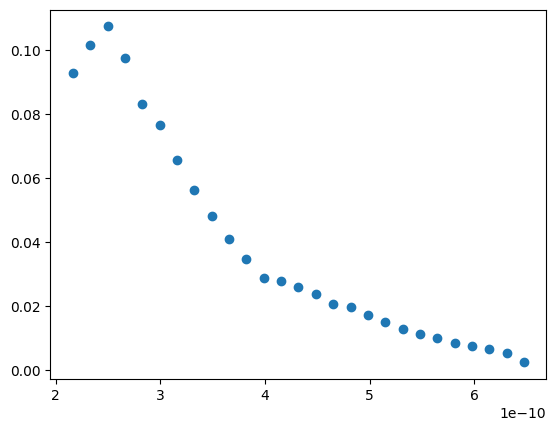

In [33]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[119::10][1:], TOFcounts[119::10][1:]

TOF *= 1e-3
TOFcountsarea = np.trapz(TOFcounts) # area under curve
TOFcountsnormed = TOFcounts/TOFcountsarea # sum is 1

TOF = TOF[TOFcountsnormed > 2e-4]
jpplammono = TOFcountsnormed[TOFcountsnormed > 2e-4]
# cuts out probabilities close to 0 (irrelevant)

jplammono = TOFtolambda(TOF, planck_const, m_neu, detector_dist)

plt.plot(jplammono, jpplammono, "o")
plt.show()

In [34]:
(271.8 + 151.1)*1e-2

4.229

In [73]:
px, py = 3e-6, 3e-6


Nbc = 5e28*4.149e-15
mt = 5

Lmono = 8.5415


lam, plam = jplammono, jpplammono
# lam, plam = jplammono[-1], 1


h = 8.53e-6


phi = Nbc*lam*h



# slitx = slitx_opt
# slity = slity_opt  
slitx = 643e-6
slity = 783e-6

xbin = 1e-6
ybin = 1e-6

res = m_per_pixel_camera2


dsimmono = np.arange(12.5,12.9,0.1)*1e-3 

L1mono = (271.8 + 151.1)*1e-2 - (dsimmono - dsimmono[0])/2
# dsimmono = ddatamono[1:]

G1sd = {"px":px, "py":py,"L1": L1mono, "phi":phi, "mt": mt, "spectrum_spacing":1, "n_p_g":10}
G1sd["L2"] = dsimmono


G2sd = {"px":px, "py":py, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi, "mt": mt, "spectrum_spacing":1, "n_p_g":10}
G2sd["L2"] = Lmono - (G1sd["L1"] + G1sd["L2"])



camsize = 1e-2
x,y = np.arange(-camsize/8,camsize/8+xbin,xbin), np.arange(-camsize/10,camsize/10 + ybin,ybin)



simapts = {"G1":RectGrating2D(G1sd), "G2":RectGrating2D(G2sd)}


siminit = {"lam":lam, "plam": plam,"bin_lam":True,"sum_lam":False, "lam_binsize":1e-10, "L":Lmono,"d":dsimmono,"mt":mt,"xbin":xbin,"ybin":ybin,\
            "gravity":True,"convmode" : "valid", "slitx": slitx, "slity" : slity,"resx": res,"resy": res, "x":x, "y":y,\
            "batches": 1000, "cam_rotdeg": 13.3}


In [74]:
t0 = time()
sim2d = PGMI(simapts, siminit)
sim2d.propagate_to("G1")
sim2d.propagate_to("G2")
sim2d.generate_after("G2")

print(time() - t0, "seconds")


(5, 27, 121, 121) (5, 27, 121) (5, 27, 121) 

(5, 27, 121, 121) (5, 121) (5, 121) 

Wavelength bins: [2.e-10 3.e-10 4.e-10 5.e-10 6.e-10]
0.4557070732116699 seconds


In [39]:
condx = np.where(np.isclose(np.abs(kx), kx_moire))
condy = np.where(np.isclose(np.abs(ky), ky_moire))
cond_0 = np.where(np.isclose(kx,0))
print(np.abs(a)[condx,condy])
print(np.abs(a)[cond_0,cond_0])

cond_0

NameError: name 'kx' is not defined

TypeError: Input z must be 2D, not 3D

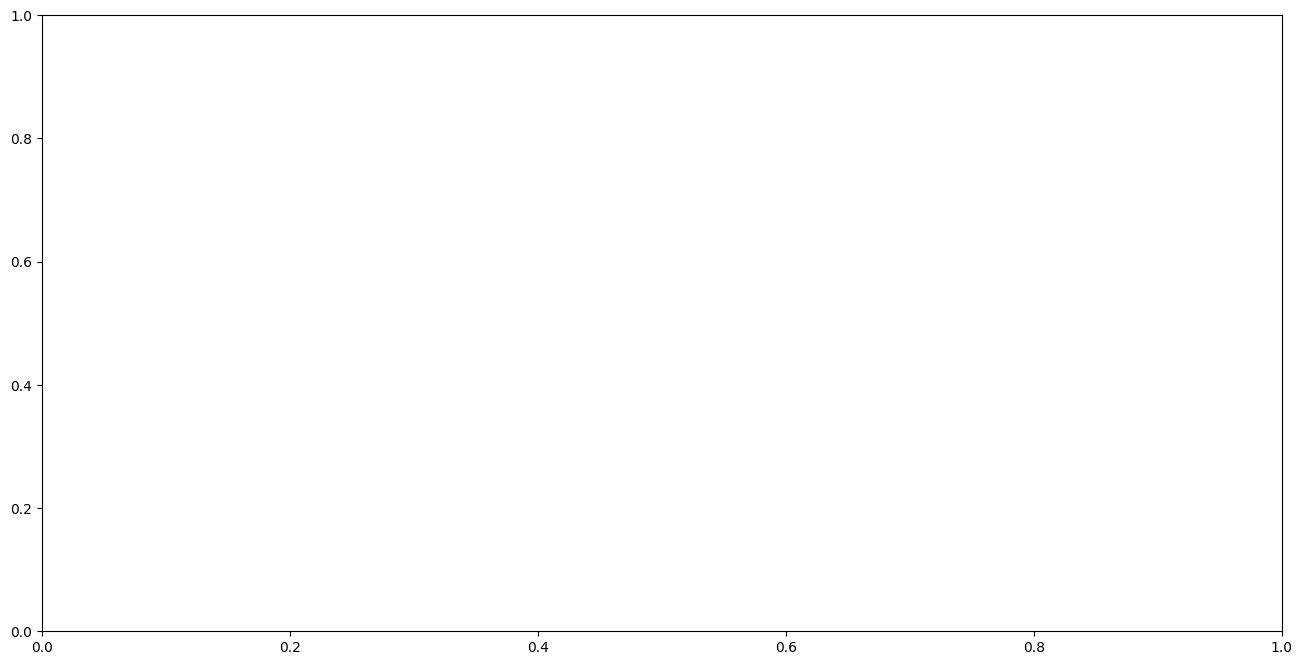

In [44]:
fig, ax = plt.subplots(figsize = (16,8))

a, kx, ky = sim2d.all_a[-1], sim2d.all_kx[-1], sim2d.all_ky[-1]
kx_moire = 2*pi / (sim2d.L*sim2d.px/sim2d.d[-1])
ky_moire = 2*pi / (sim2d.L*sim2d.py/sim2d.d[-1])


c = ax.contourf(np.abs(a)/(2*kx_moire)/(2*ky_moire), levels = 1000, origin = "lower",)# extent = (kx[0],kx[-1],ky[0],ky[-1]))
# c = ax.imshow(np.abs(a)/np.ptp(kx)/np.ptp(ky), origin = "lower", extent = (np.min(kx),np.max(kx),np.min(ky),np.max(ky)))

c.set_clim(0,5e-9)

cbar = fig.colorbar(c,)#  format = "%.3f")
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Absolute Fourier Amplitude", fontsize = 18)



ax.set_xticks(np.array([49.5,60.5,71.5]), [r"$\frac{-2\pi}{p_m}$","0", r"$\frac{2\pi}{p_m}$"])
ax.set_yticks(np.array([49.5,60.5,71.5]), [r"$\frac{-2\pi}{p_m}$","0", r"$\frac{2\pi}{p_m}$"])


ax.tick_params(axis = "x", which = "both", bottom = False, labeltop = True, labelbottom = False)
ax.tick_params(axis = "y", which = "both", right = True, labelright = True, labelleft = False)

ax.tick_params(labelsize = 20)

# ax.set_yticklabels(np.arange(4,10), fontsize = 20)

ax.set_xlabel(r"$k_x$ [m$^{-1}$]", fontsize = 20)
ax.set_ylabel(r"$k_y$ [m$^{-1}$]", fontsize = 20)


# ax.set_xlim(-2*kx_moire,2*kx_moire)
# ax.set_ylim(-2*ky_moire,2*ky_moire)
# ax.set_aspect(1)

ax.set_xlim(40,80)
ax.set_ylim(40,80)
ax.set_aspect(1)


ax.axvline(49.5, ls= "--", lw=0.7, color = "w", ymin = 0.51, ymax = 1)
ax.axvline(60.5, ls= "--", color = "w", lw = 0.7, ymin = 0.51, ymax = 1)
ax.axvline(71.5, ls= "--", lw=0.7, color = "w", ymin = 0.51, ymax = 1)

ax.axhline(49.5, ls= "--", lw=0.7, color = "w", xmin = 0.51, xmax = 1)
ax.axhline(60.5, ls= "--", color = "w", lw = 0.7, xmin = 0.51, xmax = 1)
ax.axhline(71.5, ls= "--", lw=0.7, color = "w", xmin = 0.51, xmax = 1)

# fig.savefig("2DSimulatedMomentumSpace.png",bbox_inches = "tight")
plt.show()
plt.close(fig)



In [82]:
monodataIxerror[:,-1].shape

(4,)

In [37]:
xphase_add_factors = np.arange(-1.5, 1.0, 0.05)
yphase_add_factors = np.arange(-2.5, 2.0, 0.05)

monophasex = monodataIxfitparams[:,-1] % pi - pi
monophasey = monodataIyfitparams[:,-1].copy()
monophasey %= pi
monophasey[1:] -= pi

err_monophasex = monodataIxerror[:,-1].copy()
err_monophasey = monodataIyerror[:,-1].copy()




phase_x, monophasex, err_monophasex, xphase_add_factors = force_broadcast(sim2d.phase_x, monophasex,err_monophasex, xphase_add_factors)
phase_y, monophasey, err_monophasey, yphase_add_factors = force_broadcast(sim2d.phase_y, monophasey,err_monophasey, yphase_add_factors)




phasefitxerr = np.sum(((monophasex - (phase_x+xphase_add_factors)) / err_monophasex)**2 , axis = get_param_axis(monophasex, lam_bins[:-1]))

phasefityerr = np.sum(((monophasey - (phase_y+yphase_add_factors)) / err_monophasey)**2 , axis = get_param_axis(monophasey, lam_bins[:-1]))


phasefitxerr, phasefityerr = force_broadcast(phasefitxerr, phasefityerr)


phasefitxyerr = np.sqrt(phasefitxerr + phasefityerr)





argminerr = min_index(np.array(phasefitxyerr))

# argminerr = np.array([min_index(err) for err in phasefitxyerr])

In [38]:
phasefitxyerr.shape

(5, 51, 50, 90)

In [39]:
argminerr

(1, 5, 17, 61)

In [40]:
g_fit_err = phasefitxyerr[argminerr]
all_but_g_same_err = phasefitxyerr[argminerr[0],:,argminerr[2],argminerr[3]]
g_uncert = np.abs(sim2d.g.squeeze()[argminerr[1]] - sim2d.g.squeeze()[np.argmin(np.abs(all_but_g_same_err - 2*g_fit_err))])
g_meas = sim2d.g.squeeze()[argminerr[1]]

In [41]:
g_meas

9.606649999999998

In [42]:
g_uncert

0.4499999999999904

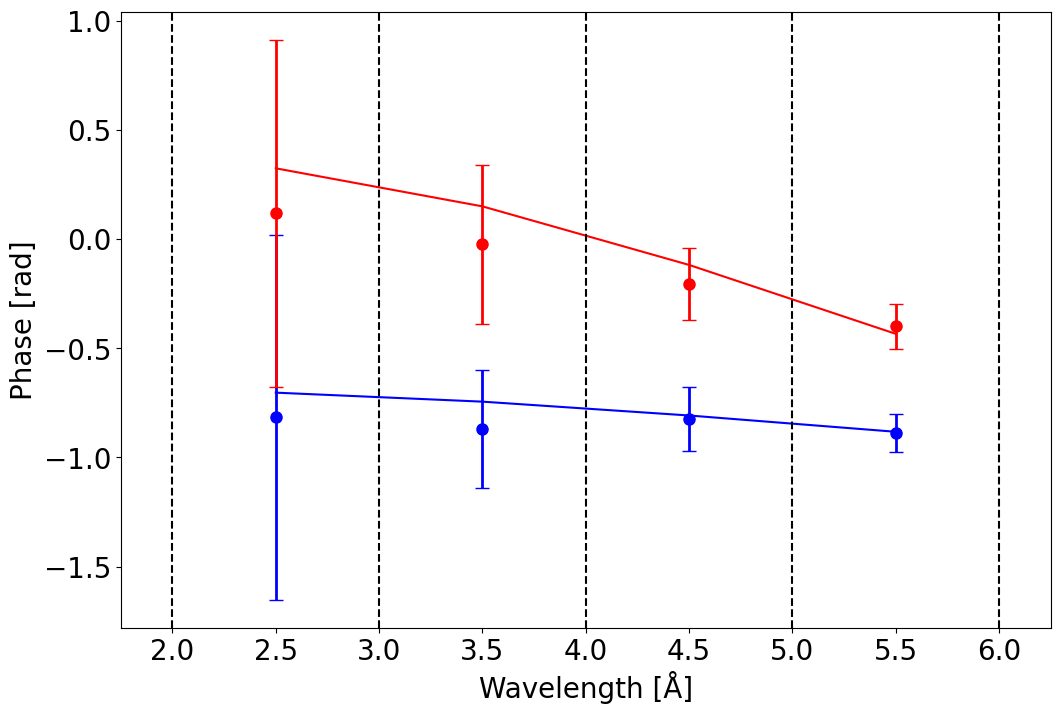

In [75]:
fig, ax1 = plt.subplots(figsize = (12,8))


ax1.set_prop_cycle(color = ["blue", "red"])



ax1.errorbar(lam_bins[:-1] + 0.5,monophasex.squeeze(), monodataIxerror[:,-1], fmt = "o",
        capsize = 5, elinewidth=2,markersize = 8, label = "Data, x")

ax1.errorbar(lam_bins[:-1] + 0.5,monophasey.squeeze(), monodataIyerror[:,-1], fmt = "o",
        capsize = 5, elinewidth=2,markersize = 8, label = "Data, y")
    

# ax1.plot(lam_bins[:-1] + 0.5, sim2d.phase_x.squeeze()[argminerr[0]] + \
#          xphase_add_factors.squeeze()[argminerr[1]],"-", label = "Simulation, x")
# ax1.plot(lam_bins[:-1] + 0.5, sim2d.phase_y.squeeze()[argminerr[0]] + \
#          yphase_add_factors.squeeze()[argminerr[2]],"-", label = "Simulation, y")

ax1.plot(lam_bins[:-1] + 0.5, sim2d.phase_x.squeeze()[argminerr[0], :,argminerr[1]] + \
         xphase_add_factors.squeeze()[argminerr[-2]],"-", label = "Simulation, x")
ax1.plot(lam_bins[:-1] + 0.5, sim2d.phase_y.squeeze()[argminerr[0], :,argminerr[1]] + \
         yphase_add_factors.squeeze()[argminerr[-1]],"-", label = "Simulation, y")




# ax1.legend(fontsize = 20)

ax1.set_xlabel(r"Wavelength [Å]", fontsize = 20)
# ax1.set_ylabel("Contrast [%]", fontsize = 20)
ax1.set_ylabel("Phase [rad]", fontsize = 20)
ax1.tick_params(labelsize = 20)

[ax1.axvline(i, color = "black", ls = "--") for i in range(2,7)]
ax1.set_xlim(1.75,6.25)

fig.savefig("2Dmonophasexy.png", bbox_inches = "tight")

plt.show()
plt.close(fig)



In [125]:
monodataIxerror.shape

(4, 3)

In [76]:
# phi_chi2_x = get_chi_sq(monophasex.squeeze(), sim2d.phase_x.squeeze()[argminerr[0]] + \
#                         xphase_add_factors.squeeze()[argminerr[1]], monodataIxerror[:,-1]) / len(monophasex.squeeze())

# phi_chi2_y = get_chi_sq(monophasey.squeeze(), sim2d.phase_y.squeeze()[argminerr[0]] + \
#                         yphase_add_factors.squeeze()[argminerr[2]], monodataIyerror[:,-1]) / len(monophasey.squeeze())

phi_chi2_x = get_chi_sq(monophasex.squeeze(), sim2d.phase_x.squeeze()[argminerr[0], :, argminerr[1]] + \
                        xphase_add_factors.squeeze()[argminerr[-2]], monodataIxerror[:,-1]) / len(monophasex.squeeze())

phi_chi2_y = get_chi_sq(monophasey.squeeze(), sim2d.phase_y.squeeze()[argminerr[0], :, argminerr[1]] + \
                        yphase_add_factors.squeeze()[argminerr[-1]], monodataIyerror[:,-1]) / len(monophasey.squeeze())

print(phi_chi2_x,
phi_chi2_y)

0.06333449642965218 0.16956693966411263


In [78]:
cont_mult_factors = np.arange(0.2, 1.3, 0.01)

contrast_x, monocontx,monocontxerror, cont_mult_factors = force_broadcast(sim2d.contrast_x[argminerr[0], :, argminerr[1]],\
                                                                          monocontx,monocontxerror, cont_mult_factors)
contrast_y, monoconty,monocontyerror, cont_mult_factors = force_broadcast(sim2d.contrast_y[argminerr[0], :, argminerr[1]],\
                                                                          monoconty,monocontyerror, cont_mult_factors)

print_shapes(contrast_x, monocontx,monocontxerror, cont_mult_factors)

contfitxerr = np.sum((monocontx - (contrast_x*cont_mult_factors))**2, axis = 0)

contfityerr = np.sum((monoconty - (contrast_y*cont_mult_factors))**2, axis = 0)

contfitxyerr = np.sqrt(contfitxerr + contfityerr)


print(contfitxyerr.shape)

cont_argminerr = min_index(np.array(contfitxyerr))


(4, 1) (4, 1) (4, 1) (1, 110) 

(110,)


In [79]:
cont_argminerr

(36,)

In [80]:
monocontx, sim2d.contrast_x, monocontxerror, cont_mult_factors, monoconty, sim2d.contrast_y, monocontyerror, cont_mult_factors =\
[np.squeeze(i) for i in [monocontx, sim2d.contrast_x, monocontxerror, cont_mult_factors, monoconty, sim2d.contrast_y, monocontyerror, cont_mult_factors]]

In [81]:
sim2d.contrast_x.shape

(5, 4, 51)

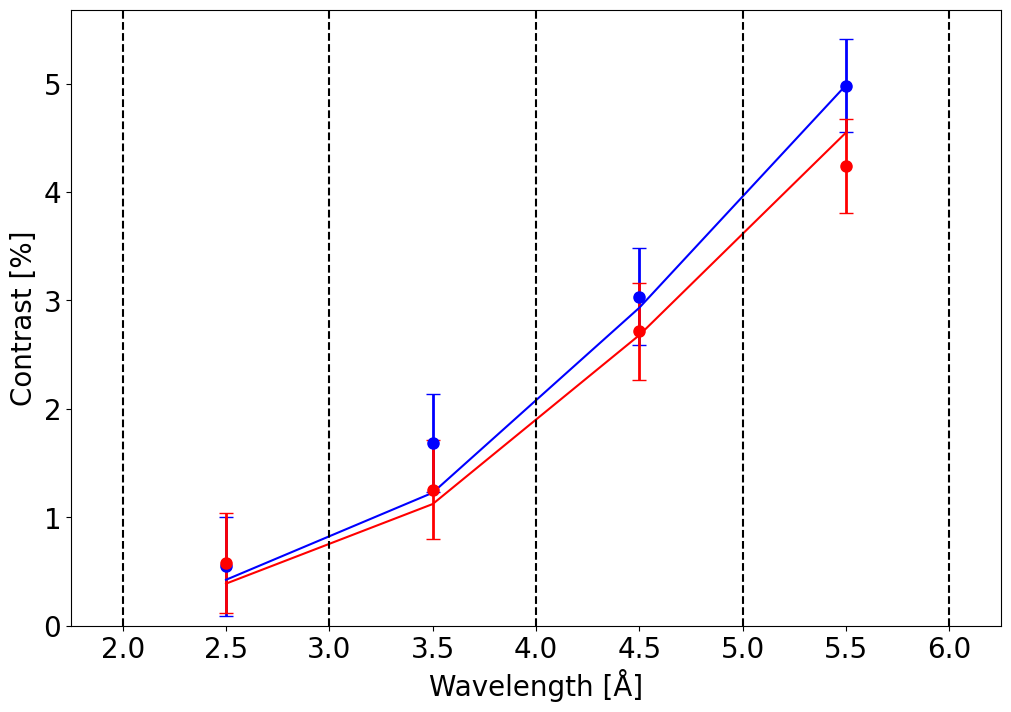

In [83]:
fig, ax1 = plt.subplots(figsize = (12,8))


ax1.set_prop_cycle(color = ["blue", "red"])      
ax1.errorbar(lam_bins[:-1] + 0.5,monocontx*1e2, yerr = monocontxerror*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, x",fmt = "o", markersize = 8)

ax1.errorbar(lam_bins[:-1] + 0.5,monoconty*1e2, yerr = monocontyerror*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, y",fmt = "o", markersize = 8)

        



ax1.plot(lam_bins[:-1] + 0.5, sim2d.contrast_x[argminerr[0], :, argminerr[1]]*cont_mult_factors[cont_argminerr]*1e2, "-",\
        label = "Simulation, x")
ax1.plot(lam_bins[:-1] + 0.5, sim2d.contrast_y[argminerr[0], :, argminerr[1]]*cont_mult_factors[cont_argminerr]*1e2, "-",\
        label = "Simulation, y")
# Have to use same d for phase and contrast, using d with best fit over both plots




# ax1.legend(fontsize = 20)

ax1.set_xlabel(r"Wavelength [Å]", fontsize = 20)
ax1.set_ylabel("Contrast [%]", fontsize = 20)



ax1.tick_params(labelsize = 20)
[ax1.axvline(i, color = "black", ls = "--") for i in range(2,7)]
ax1.set_xlim(1.75,6.25)
ax1.set_ylim(0)
fig.savefig("2Dmonocontrastxy.png", bbox_inches = "tight")

plt.show()
plt.close(fig)



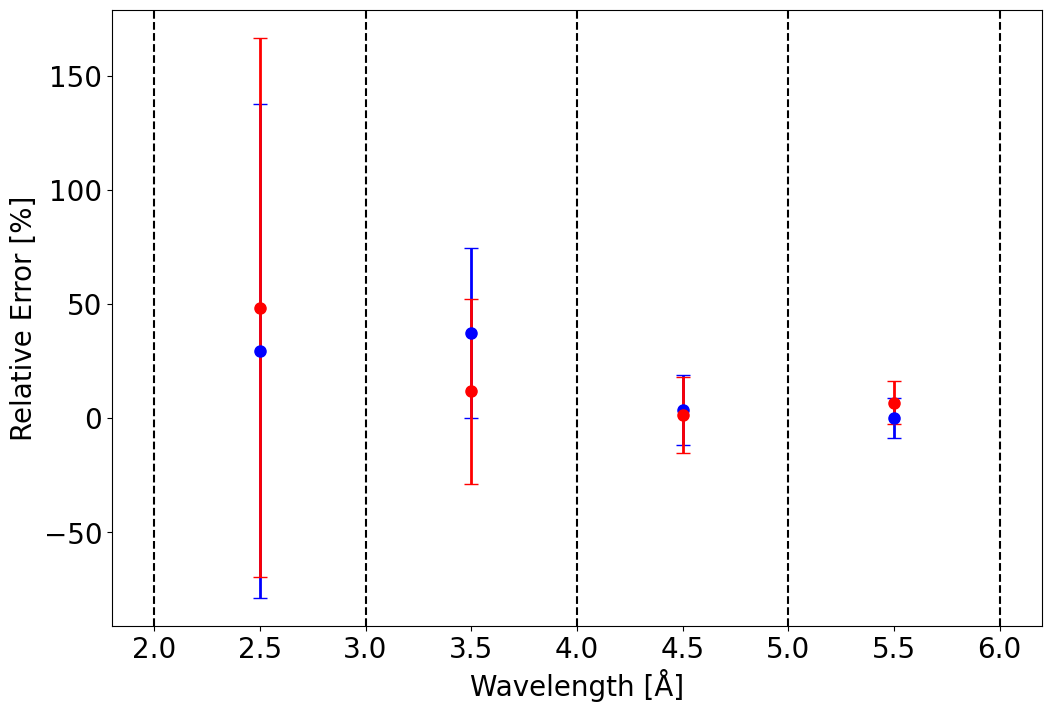

In [86]:
fig, ax1 = plt.subplots(figsize = (12,8))

contsimx = sim2d.contrast_x[argminerr[0], :, argminerr[1]]*cont_mult_factors[cont_argminerr]
contsimy = sim2d.contrast_y[argminerr[0], :, argminerr[1]]*cont_mult_factors[cont_argminerr]


ax1.set_prop_cycle(color = ["blue", "red"])      
ax1.errorbar(lam_bins[:-1] + 0.5, (np.abs(monocontx - contsimx)/contsimx) * 1e2, yerr = (monocontxerror/contsimx)*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, x",fmt = "o", markersize = 8)

ax1.errorbar(lam_bins[:-1] + 0.5,(np.abs(monoconty - contsimy)/contsimy) * 1e2, yerr = (monocontyerror/contsimy)*1e2, capsize = 5, elinewidth = 2,\
    label = "Data, y",fmt = "o", markersize = 8)

# ax1.plot(lam_bins[:-1] + 0.5, (np.abs(monocontx - contsimx)/contsimx) * 1e2,"o-",  label = "Data, x")

# ax1.plot(lam_bins[:-1] + 0.5,(np.abs(monoconty - contsimy)/contsimy) * 1e2,"o-", label = "Data, y")




# Have to use same d for phase and contrast, using d with best fit over both plots




# ax1.legend(fontsize = 20)

ax1.set_xlabel(r"Wavelength [Å]", fontsize = 20)
ax1.set_ylabel("Relative Error [%]", fontsize = 20)



ax1.tick_params(labelsize = 20)
[ax1.axvline(i, color = "black", ls = "--") for i in range(2,7)]
# ax1.set_xlim(1.75,6.25)
# ax1.set_ylim(0)
fig.savefig("monocontresiduals.png", bbox_inches = "tight")

plt.show()
plt.close(fig)

